# Task 5. Parallell Bifurcation diagram
Parallel the code by r's

In [6]:
%%writefile bifurcation.py

from mpi4py import MPI
from random import uniform
import numpy as np

# import matplotlib.pyplot as plt
from datetime import datetime

def x_next(x, r):
    x_next = x*r*(1-x)
    return x_next


startTime = datetime.now()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

r_num = 10000
n = 1000
m = 200
r_s = np.linspace(2, 4.0, r_num)
x_s = uniform(0, 1) * np.ones(len(r_s))
slice_index = np.linspace(0, len(r_s), size + 1, endpoint=False, dtype=int)
slice_index[-1] = len(r_s)

x_ss = []
r = r_s[slice_index[rank]:slice_index[rank+1]]
x = x_s[slice_index[rank]:slice_index[rank+1]]

for i in range(n):
    x = x_next(x, r)
    if i >= n - m:
        x_ss.append(x)

full_data = comm.gather([x_ss, r], root=0)

if rank == 0:
#     for data in full_data:
#         for x in data[0]:
#             plt.plot(data[1], x, ',k', alpha=.25)

#     plt.savefig('bif' + str(size) + '.png')
    print(datetime.now() - startTime)

Overwriting bifurcation.py


In [33]:
# !pip install mpi4py

In [3]:
proc = np.arange(1, 16)

## Run on 4 core processor (Intel Core i7)

In [54]:
import mpi4py
import numpy as np
import matplotlib.pyplot as plt

bif_time = []

for i in proc:
    time = !mpiexec -np {i} python bifurcation.py
    bif_time.append(float(time[0][-8:]))
    print (time[0][-8:])

0.035243
0.035899
0.028337
0.028800
0.077025
0.039341
0.111596
0.044063
0.131954
0.087558
0.128863
0.142950
0.230723
0.209816
0.114397


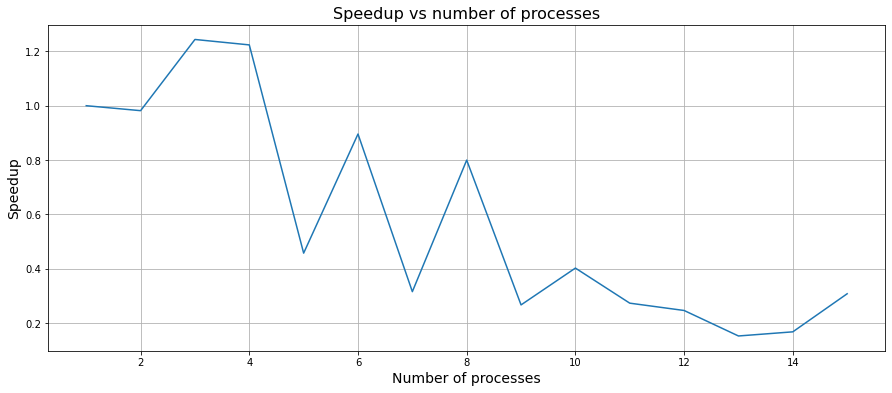

In [55]:
plt.figure(figsize=(15, 6))
plt.plot(proc, bif_time[0] / np.array(bif_time))
plt.title('Speedup vs number of processes', size=16)
plt.xlabel('Number of processes', size=14)
plt.ylabel('Speedup', size=14)
plt.grid(True);

## Run on Zhores

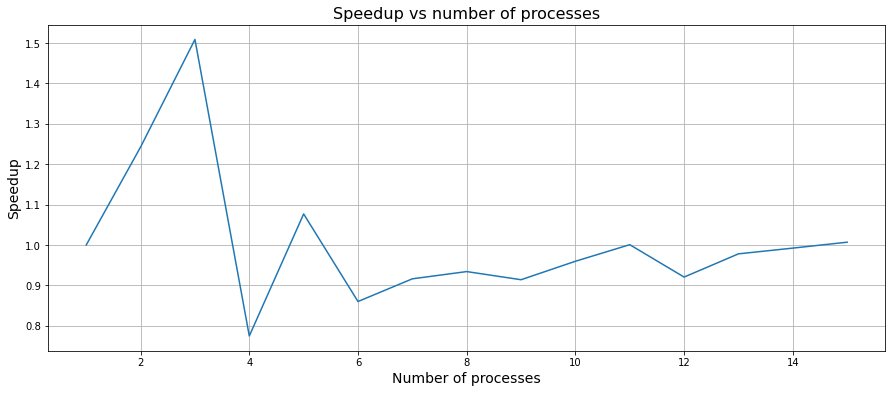

In [4]:
arr = [0.060170,
0.048423,
0.039877,
0.077674,
0.055876,
0.069967,
0.065674,
0.064414,
0.065837,
0.062699,
0.060127,
0.065366,
0.061523,
0.060642,
0.059759]

plt.figure(figsize=(15, 6))
plt.plot(proc, arr[0] / np.array(arr))
plt.title('Speedup vs number of processes', size=16)
plt.xlabel('Number of processes', size=14)
plt.ylabel('Speedup', size=14)
plt.grid(True);

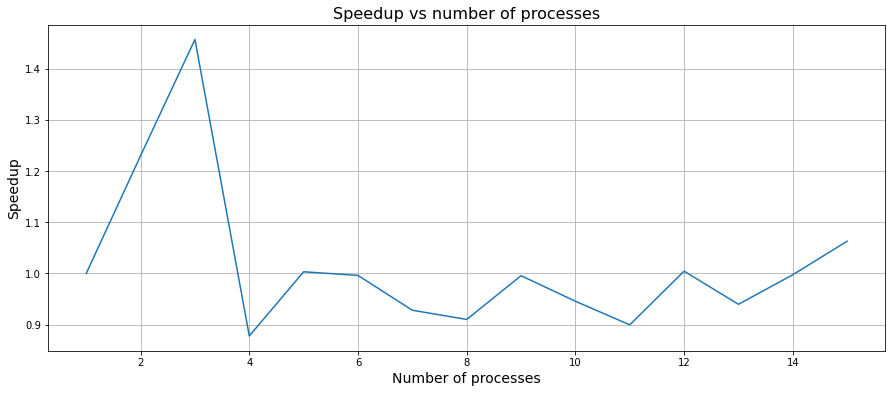

In [7]:
arr = [0.060619,
0.049278,
0.041601,
0.069058,
0.060423,
0.060854,
0.065317,
0.066606,
0.060890,
0.064102,
0.067389,
0.060352,
0.064509,
0.060775,
0.057025]

plt.figure(figsize=(15, 6))
plt.plot(proc, arr[0] / np.array(arr))
plt.title('Speedup vs number of processes', size=16)
plt.xlabel('Number of processes', size=14)
plt.ylabel('Speedup', size=14)
plt.grid(True);

# Task 6. Parallel Spectrogram
Parallel the code by windows

In [5]:
%%writefile spectrogram.py

# import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime 
from numpy import fft 
from numpy import exp, pi
from mpi4py import MPI

def form_signal(n_timestamps = 4096):
    t = np.linspace(-20*2*pi, 20*2*pi, n_timestamps)
    y = np.sin(t)*exp(-t**2/2/20**2)               # generate first  wave packets of harmonic signal
    y = y + np.sin(3*t)*exp(-(t-5*2*pi)**2/2/20**2)  # add      second wave packets of harmonic signal
    y = y + np.sin(5*t)*exp(-(t-10*2*pi)**2/2/10**2) # add      third  wave packets of harmonic signal
    y = y + np.sin(4*t)*exp(-(t-7*2*pi)**2/2/20**2)
    
    return t, y

def window_function(t, window_position, window_width):
    return exp(-(t - window_position)**2/2/window_width**2)

def get_specgram_data_t_window_positions(t, y, t_window_positions, window_width, nwindowsteps=1000):
    specgram = np.empty([len(t), len(t_window_positions)])

    for i,t_window_position in enumerate(t_window_positions):
        y_window = y*window_function(t, t_window_position, window_width)
        specgram[:, i]=abs(fft.fft(y_window))

    return specgram

def my_ifig(x, y, z, title, xlabel, ylabel, grid_active=False, fig_x_size=15, fig_y_size=10, font_param=20):
    w = fft.fftfreq(len(y), d=(t[1]-t[0])/2/pi)
    plt.figure(figsize=(fig_x_size, fig_y_size))
    plt.imshow(z, aspect='auto', origin='lower', 
               extent=[min(x)/2/pi, max(x)/2/pi, y[0], 2 * w[int(len(x)/2)-1]])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=font_param)
    plt.title(title, fontsize = font_param * 1.3)
    plt.xlabel(xlabel, fontsize = font_param)
    plt.ylabel(ylabel, fontsize = font_param)
    plt.xticks(fontsize = font_param)
    plt.yticks(fontsize = font_param)
    plt.grid(grid_active)
    plt.ylim(0, 10)
    plt.savefig(title+'.png', bbox_inches='tight', dpi=300)

    
startTime = datetime.now()    
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nprocs = comm.Get_size()

t, y = form_signal(50000)
t_window_positions = np.linspace(-20*2*pi, 20*2*pi, 1000)
slice_index = np.linspace(0, t_window_positions.shape[0], nprocs+1, endpoint=False, dtype=int)
slice_index[-1] = t_window_positions.shape[0]
spectrogram = get_specgram_data_t_window_positions(t, y, 
                                t_window_positions[slice_index[rank]:slice_index[rank+1]],
                                window_width=20, nwindowsteps=1000)

data_from_proc = comm.gather(spectrogram, root=0)

if rank == 0:
    res_spectrogram = np.hstack(data_from_proc)
#     my_ifig(t, y, res_spectrogram, 'parallel_spectrogram', 'time', 'freq')
    print(datetime.now() - startTime)# 4. Parallell Bifurcation diagram

Overwriting spectrogram.py


In [ ]:
proc = np.arange(1, 16)

In [6]:
# !pip install mpi4py

## Run on 4 core processor (Intel Core i7)

In [10]:
import mpi4py
import numpy as np
import matplotlib.pyplot as plt

bif_time = []

for i in proc:
    time = !mpiexec -np {i} python bifurcation.py
    bif_time.append(float(time[0][-8:]))
    print (time[0][-8:])

0.035200
0.030914
0.028418
0.029280
0.050333
0.103492
0.035484
0.065690
0.085020
0.092348
0.155726
0.236653
0.111238
0.322696
0.356666


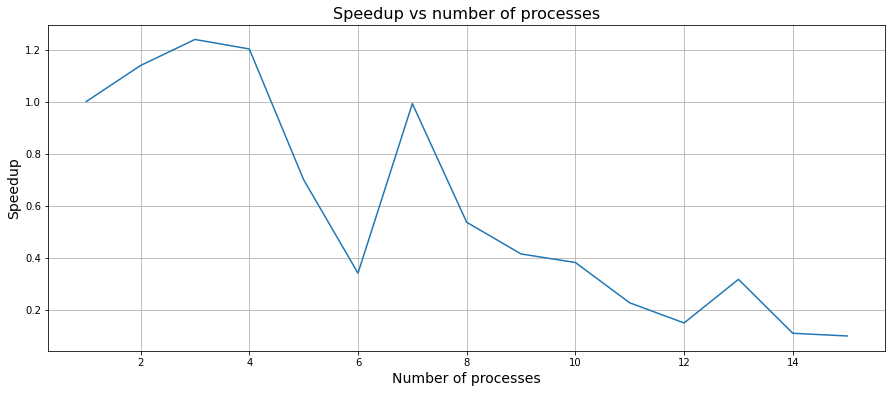

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(proc, bif_time[0] / np.array(bif_time))
plt.title('Speedup vs number of processes', size=16)
plt.xlabel('Number of processes', size=14)
plt.ylabel('Speedup', size=14)
plt.grid(True);

## Run on Zhores

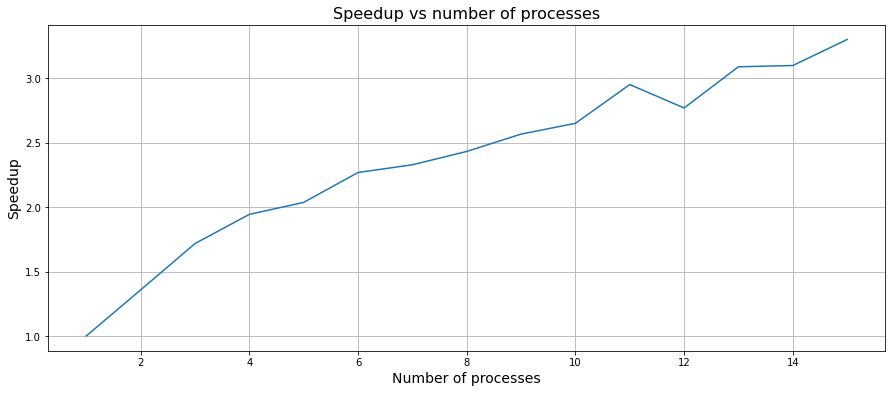

In [9]:
arr = [4.308522,
3.174508,
2.509027,
2.216332,
2.115083,
1.898712,
1.849827,
1.771113,
1.678236,
1.625275,
1.459644,
1.555319,
1.394399,
1.389891,
1.304807]

plt.figure(figsize=(15, 6))
plt.plot(proc, arr[0] / np.array(arr))
plt.title('Speedup vs number of processes', size=16)
plt.xlabel('Number of processes', size=14)
plt.ylabel('Speedup', size=14)
plt.grid(True);